In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, plot_metric, make_axis_great_again, plot_epochs, plot_lr
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '12.05_20.05_near_complete_pipeline'

In [7]:
def plot_job(ax, job_id, title, training_batch_size, metrics_ylim):
    exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(current_milestone / '{}.out'.format(job_id))
    batch_amount_per_epoch = np.ceil(train_data_amount / training_batch_size)
    n_epochs = 900  # len(epochs)
    xrange = np.arange(1, n_epochs + 1) * batch_amount_per_epoch
    
    plot_epochs(
        ax, epochs, xrange,
        train_metric_ylim=metrics_ylim,
        eval_metric_ylim=metrics_ylim,
        normalize_loss=(0, 1),
        title=title,
        metric_ylabel='average MPJPE relative to pelvis (mm)',
        xlabel='# batch iterations'
    )
    plot_lr(ax, lr_reductions, batch_amount_per_epoch)
    
    make_axis_great_again(ax, xlim=xrange, ylim=[0, 1], hide_y=True)
    
    
def plot_jobs(jobs, titles, training_batch_size=8, metrics_ylim=[0, 1e2]):
    fig, axis = get_figa(len(jobs), 1, heigth=12, width=30)  # 1 job foreach row
    
    for ax, job_id, title in zip(axis.ravel(), jobs, titles):
        plot_job(ax, job_id, title, training_batch_size, metrics_ylim)

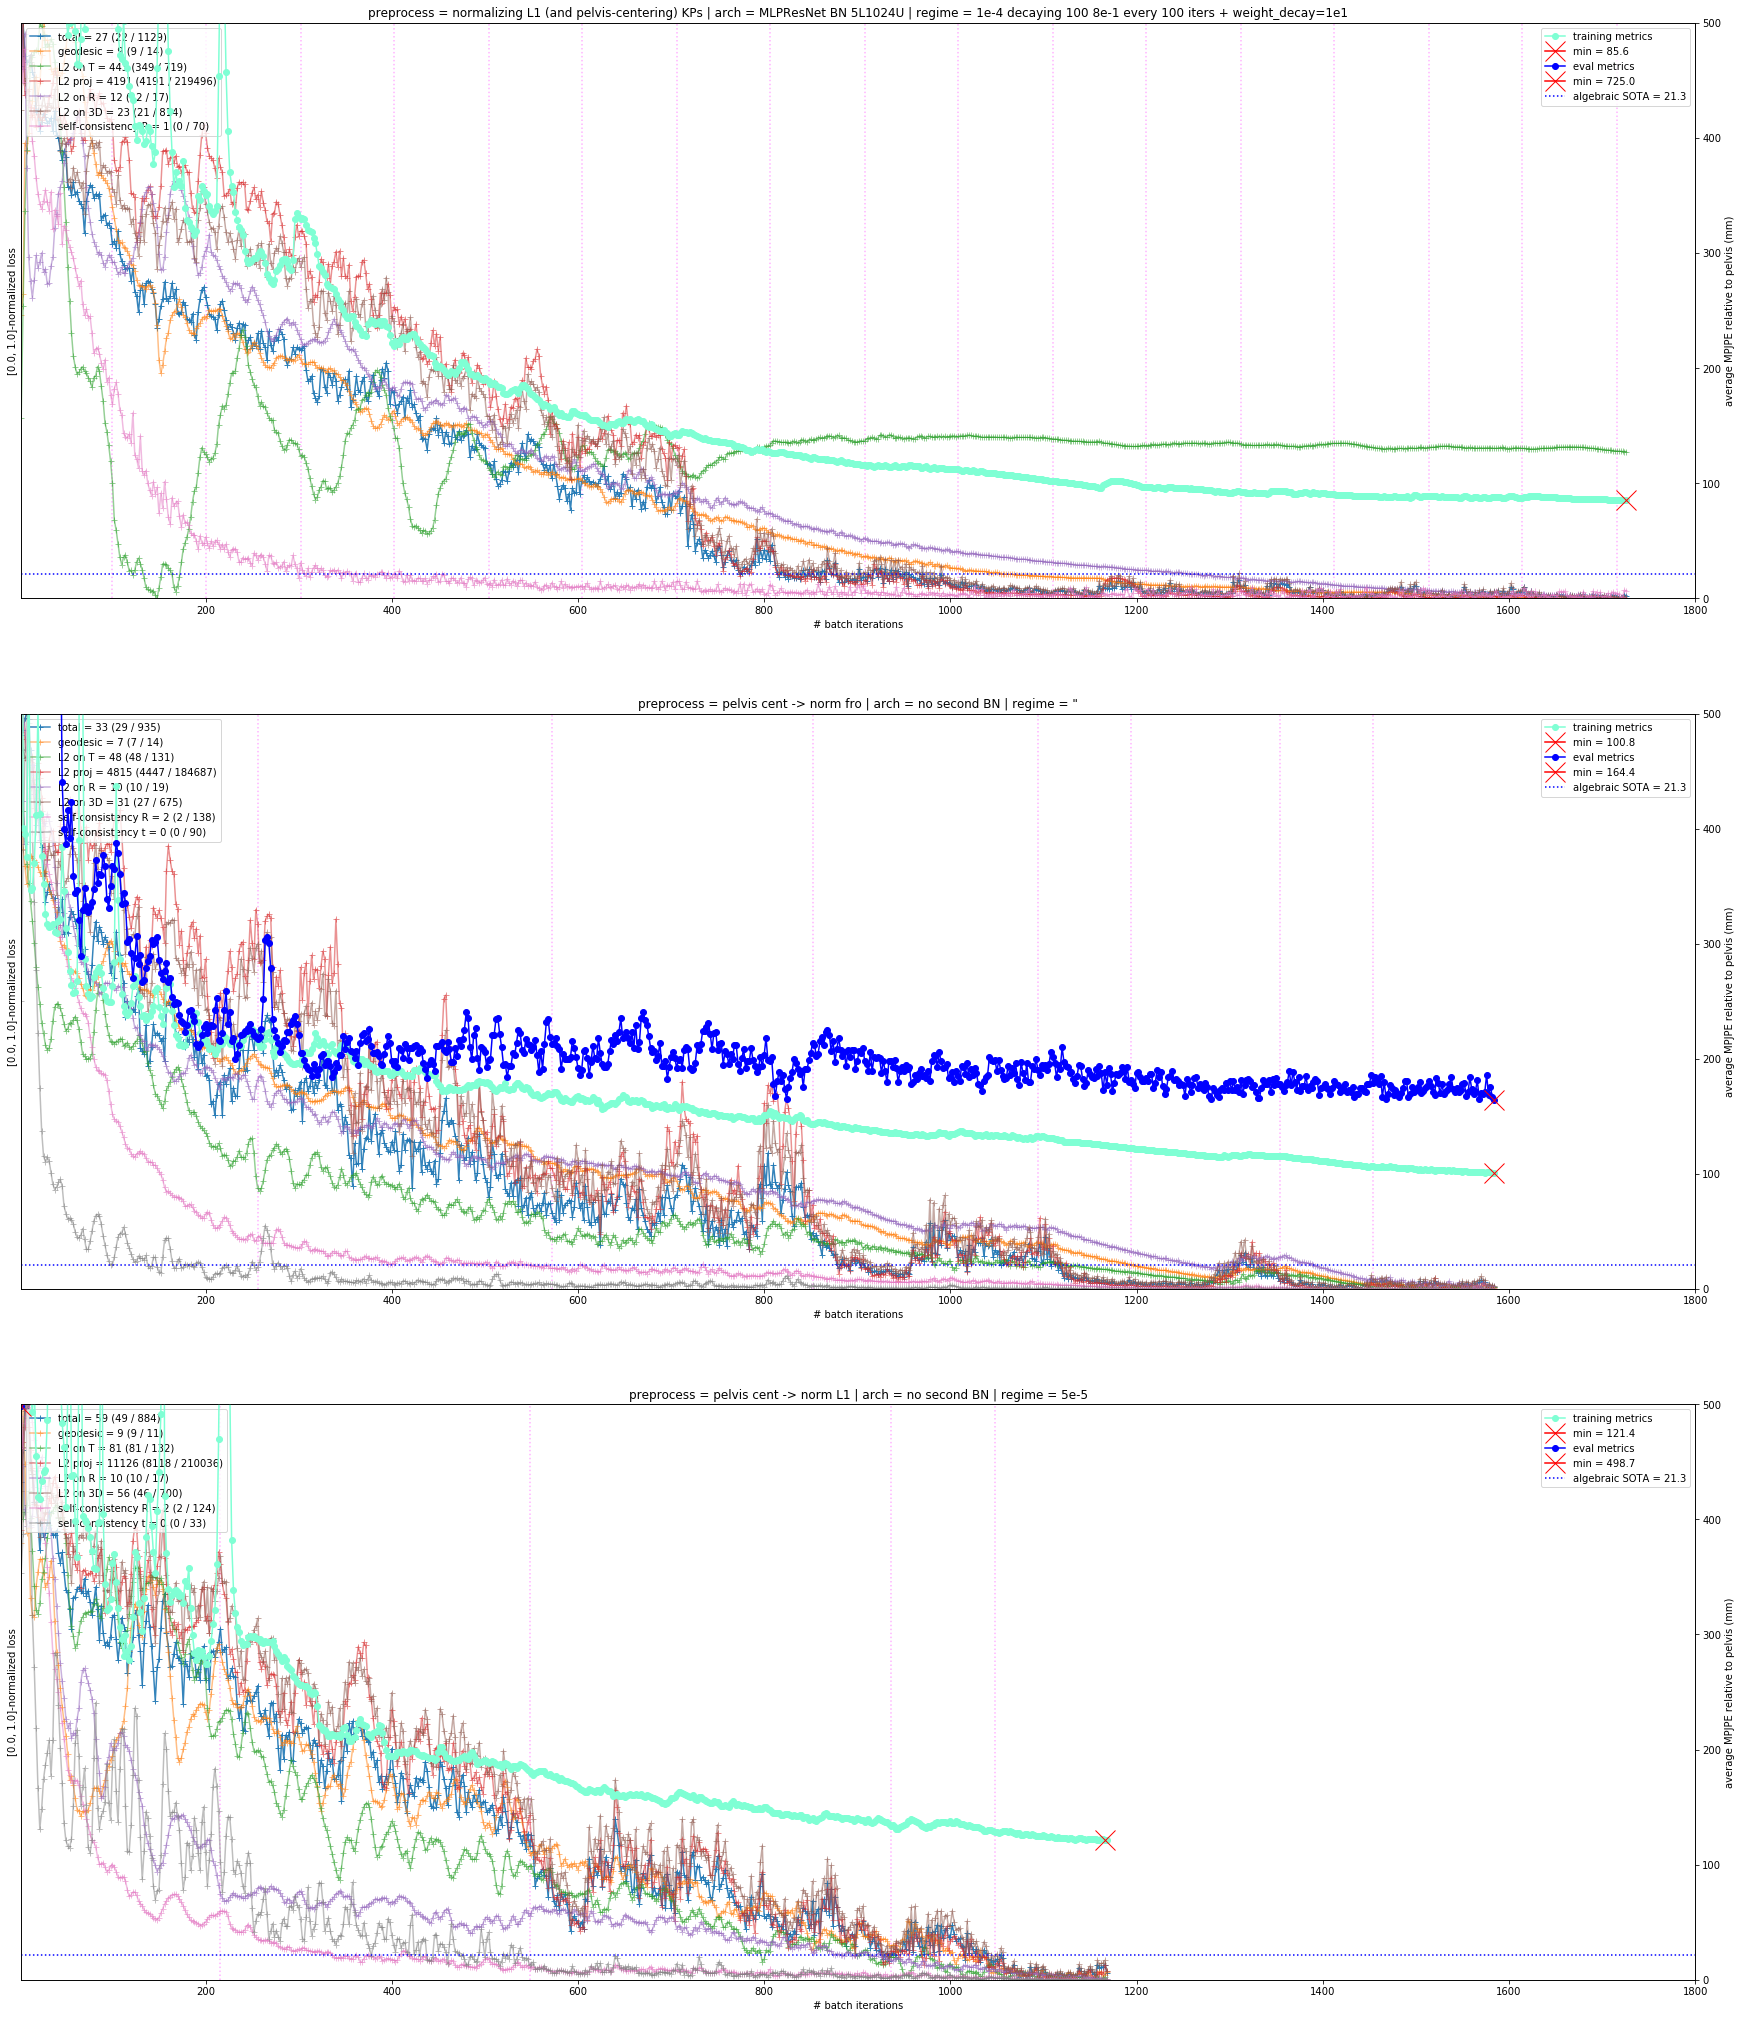

In [69]:
title = 'preprocess = {} | arch = {} | regime = {}'
common_setup = 'KISS (normalizing KPs), no lr decay'
jobs = list(zip(*[
    ('15781997', title.format('normalizing L1 (and pelvis-centering) KPs', 'MLPResNet BN 5L1024U', '1e-4 decaying 100 8e-1 every 100 iters + weight_decay=1e1')),
    ('15827642', title.format('pelvis cent -> norm fro', 'no second BN', '')),
    ('15829357', title.format('pelvis cent -> norm L1', 'no second BN', '5e-5')),
    ('15832522', title.format('pelvis cent -> norm fro', 'no second BN', '')),
]))  # human readable form

plot_jobs(jobs[0], jobs[1], metrics_ylim=[0, 5e2])  # .png